In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import math

Using TensorFlow backend.


In [2]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

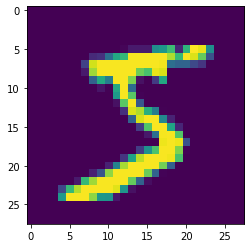

In [3]:
plt.imshow(X_train[0])
plt.show()

In [4]:
X_train = X_train.reshape((*X_train.shape,1))
print(X_train.shape)

(60000, 28, 28, 1)


In [5]:
X_train = (X_train.astype('float32') - 127.5)/127.5
print(np.min(X_train))
print(np.max(X_train))

-1.0
1.0


In [ ]:
Total_epochs = 50
batch_size = 256
no_of_batches = math.ceil(X_train.shape[0]/batch_size)
half_batch_size = 128
noise_dim = 100
adam = Adam(lr=2e-4,beta_1=0.5) 

In [7]:
generator_model = Sequential()
generator_model.add(Dense(7*7*128,input_shape = (noise_dim,)))
generator_model.add(Reshape((7,7,128)))
generator_model.add(LeakyReLU(0.2))
generator_model.add(BatchNormalization())

generator_model.add(UpSampling2D())
generator_model.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator_model.add(LeakyReLU(0.2))
generator_model.add(BatchNormalization())

generator_model.add(UpSampling2D())
generator_model.add(Conv2D(1,kernel_size=(5,5),padding='same',activation='tanh'))

generator_model.compile(loss='binary_crossentropy',optimizer=adam)
generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)       

In [8]:
discriminator_model = Sequential()
discriminator_model.add(Conv2D(64,(5,5),strides = (2,2),padding='same',input_shape = (28,28,1)))
discriminator_model.add(LeakyReLU(0.2))

discriminator_model.add(Conv2D(128,(5,5),strides = (2,2),padding = 'same'))
discriminator_model.add(LeakyReLU(0.2))
discriminator_model.add(Flatten())
discriminator_model.add(Dense(1,activation='sigmoid'))

discriminator_model.compile(loss='binary_crossentropy',optimizer=adam)
discriminator_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [9]:
discriminator_model.trainable = False
gan_input = Input(shape=(noise_dim,))
gan_image = generator_model(gan_input)
gan_output = discriminator_model(gan_image)

In [10]:
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

In [11]:
def saveImages(epoch,samples=100):
    noise = np.random.normal(0,1,size=(samples,noise_dim))
    gen_images = generator_model.predict(noise)
    gen_images = gen_images.reshape(samples,28,28)
    
    plt.figure(figsize = (10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(gen_images[i],interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images_dc/gen_image_output{}.png'.format(epoch))
    plt.show()

C:\Users\jgoel\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\jgoel\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\jgoel\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 D loss: 43.479278 G loss: 37.831412
Epoch 2 D loss: 136.209621 G loss: 140.991516
Epoch 3 D loss: 162.075681 G loss: 202.354506
Epoch 4 D loss: 161.149931 G loss: 200.878523
Epoch 5 D loss: 161.954646 G loss: 196.462343
Epoch 6 D loss: 161.930797 G loss: 195.017136
Epoch 7 D loss: 161.840897 G loss: 193.924712
Epoch 8 D loss: 161.542965 G loss: 194.696883
Epoch 9 D loss: 161.285148 G loss: 195.430134
Epoch 10 D loss: 161.176509 G loss: 195.747017


C:\Users\jgoel\Anaconda3\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


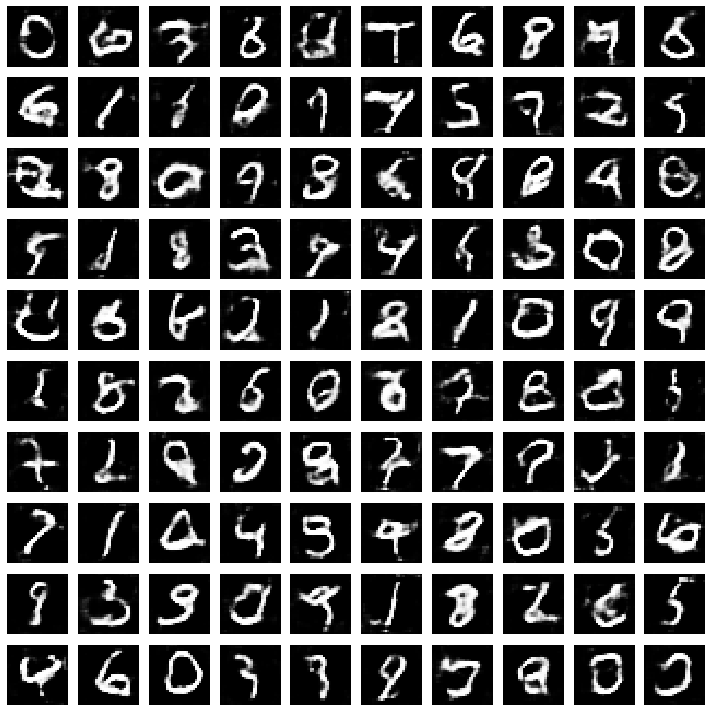

Epoch 11 D loss: 161.050408 G loss: 195.101033
Epoch 12 D loss: 160.773237 G loss: 197.320578
Epoch 13 D loss: 160.791845 G loss: 196.353275
Epoch 14 D loss: 160.469788 G loss: 197.779542
Epoch 15 D loss: 160.500462 G loss: 197.140573
Epoch 16 D loss: 160.408471 G loss: 196.458924
Epoch 17 D loss: 159.930712 G loss: 201.313690
Epoch 18 D loss: 160.011477 G loss: 197.695215
Epoch 19 D loss: 159.494153 G loss: 201.786801
Epoch 20 D loss: 159.665707 G loss: 199.331921


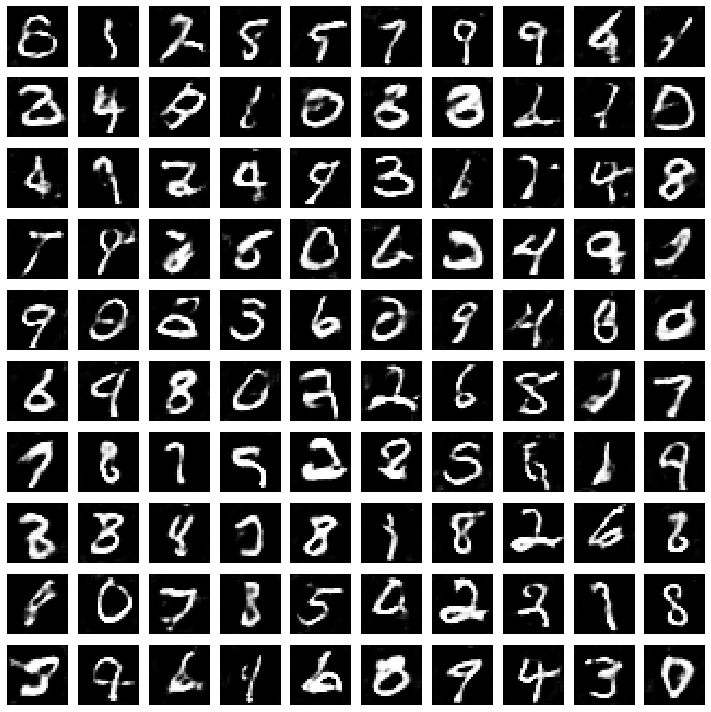

Epoch 21 D loss: 159.390002 G loss: 200.794014
Epoch 22 D loss: 158.986265 G loss: 204.707012
Epoch 23 D loss: 159.017359 G loss: 201.207863
Epoch 24 D loss: 158.799221 G loss: 202.248244
Epoch 25 D loss: 158.156824 G loss: 209.766731
Epoch 26 D loss: 158.275857 G loss: 204.132350
Epoch 27 D loss: 158.050937 G loss: 204.996864
Epoch 28 D loss: 157.833886 G loss: 206.534119
Epoch 29 D loss: 157.362386 G loss: 210.895153
Epoch 30 D loss: 157.115695 G loss: 207.823835


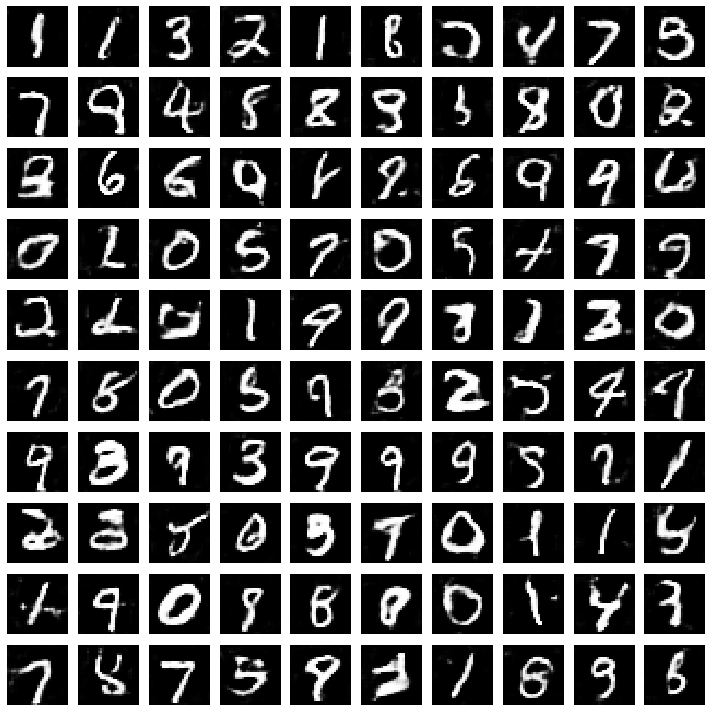

In [ ]:
d_loss_list = []
g_loss_list = []
for epoch in range(1,Total_epochs+1):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    for step in range(no_of_batches):
        idx = np.random.randint(0,X_train.shape[0],half_batch_size)
        real_images = X_train[idx]
        
        noise = np.random.normal(0,1,size=(half_batch_size,noise_dim))
        fake_images = generator_model.predict(noise)
        
        real_y = np.ones((half_batch_size,1)) * 0.9
        fake_y = np.zeros((half_batch_size,1))
        
        d_loss_real = discriminator_model.train_on_batch(real_images,real_y)
        d_loss_fake = discriminator_model.train_on_batch(fake_images,fake_y)
        
        d_loss = (d_loss_fake+d_loss_real)/2.0 
        
        epoch_d_loss += d_loss
        
        #Train Generator in which Discriminator is frozen
        noise_ground = np.random.normal(0,1,size=(batch_size,noise_dim))
        ground_truth_y = np.ones((batch_size,1))
        g_loss = model.train_on_batch(noise_ground,ground_truth_y)
        epoch_g_loss += g_loss
    print("Epoch %d D loss: %f G loss: %f" % ((epoch), epoch_d_loss, epoch_g_loss))
    d_loss_list.append(epoch_d_loss)
    g_loss_list.append(epoch_g_loss)
    if epoch%10==0:
        generator_model.save("model_dc/generator{}.h5".format(epoch))
        saveImages(epoch)

In [ ]:
plt.plot(g_loss_list,label="Generator Loss")
plt.plot(d_loss_list,label="Discriminator Loss")
plt.title("Loss")
plt.legend()
plt.show()